Baseline SVC Predictions
Baseline accuracy=0.9556, macro F1=0.9556

Optimizing SVM hyperparameters with SFOA
Best (logC, logG): [ 2.73587054 -3.27239617]
Decoded: C=544.3, gamma=0.0005341
Accuracy=1.0000, Macro F1=1.0000

Optimizing SVM hyperparameters with PSO
Best (logC, logG): [ 1.31201145 -1.85988411]
Decoded: C=20.51, gamma=0.01381
Accuracy=1.0000, Macro F1=1.0000

Optimizing SVM hyperparameters with DE
Best (logC, logG): [ 2.67624862 -3.26348931]
Decoded: C=474.5, gamma=0.0005451
Accuracy=1.0000, Macro F1=1.0000

Final Summary
SFOA: acc=1.0000, F1=1.0000, C=544.3, gamma=0.0005341
PSO: acc=1.0000, F1=1.0000, C=20.51, gamma=0.01381
DE: acc=1.0000, F1=1.0000, C=474.5, gamma=0.0005451


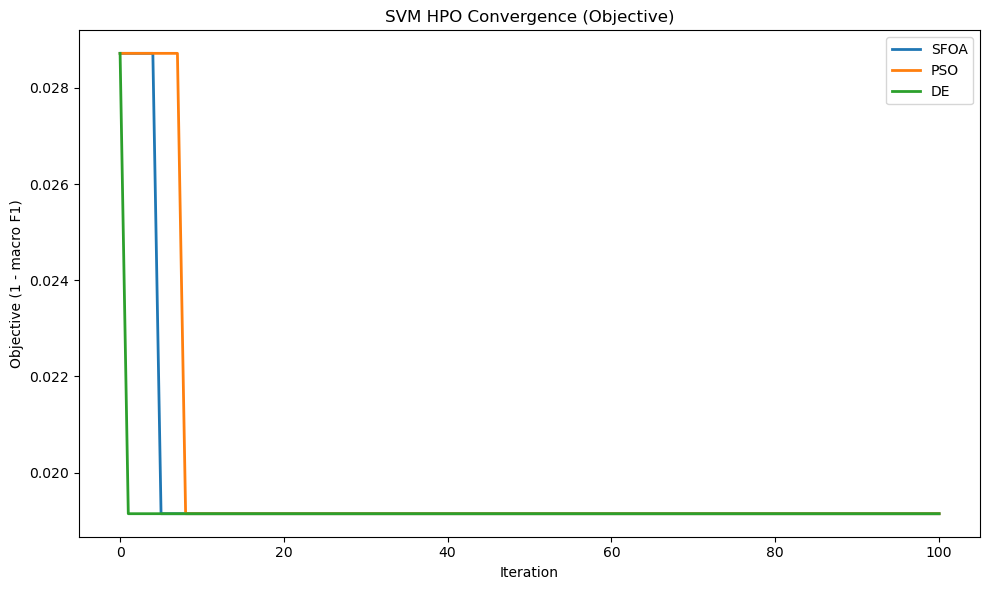

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

from SFOA import sfoa
from DE import de
from PSO import pso
import os
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="3"

def plot_convergence_hpo(curve_dict, title="SVM HPO Convergence", show_f1=False):
    plt.figure(figsize=(10, 6))

    for name, curve in curve_dict.items():
        curve = np.array(curve, dtype=float)

        if show_f1:
            #Objective is 1 - F1 to minimize for SFOA
            f1_curve = 1.0 - curve
            #Optionally show best so far F1
            best_f1 = np.maximum.accumulate(f1_curve)
            plt.plot(best_f1, label=name, linewidth=2)
            ylabel = "Best Macro F1 so far"
        else:
            plt.plot(curve, label=name, linewidth=2)
            ylabel = "Objective (1 - macro F1)"

    plt.xlabel("Iteration")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
def make_svm_objective(X, y, n_splits=5, random_state=None):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    def obj(log_params):
        log_params = np.asarray(log_params, dtype=float)
        logC, logG = log_params[0], log_params[1]

        C = 10.0 ** logC
        gamma = 10.0 ** logG

        clf = SVC(kernel="rbf",  C=C, gamma=gamma)

        scores = cross_val_score(clf, X, y, cv=cv, scoring="f1_macro")
        mean_f1 = scores.mean()
        
        return float(1.0 - mean_f1)
    
    return obj

def decode_svm_params(best_pos):
    logC, logG = best_pos
    C =  10.0 ** logC
    gamma = 10.0 ** logG

    return C, gamma

def evaluate_on_test(C, gamma, X_train, X_test, y_train, y_test):
    clf = SVC(kernel="rbf", C=C, gamma=gamma)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    return acc, f1

def main():
    #Import data from iris.csv
    df = pd.read_csv("data/iris.csv")

    #Set feature and target columns
    feature_cols = ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]
    target_col = "Species"

    #Set X and y as those values
    X = df[feature_cols].values
    y = df[target_col].astype("category").cat.codes.values

    #Create training/tuning split on 70/30
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        stratify=y,
        random_state=42
    )

    #Create param bounds for optimizers
    bounds = [
        (-3.0, 3.0), #log10(C)
        (-4.0, 1.0) #log10(gamma)
    ]

    #Build svm objectives
    svm_obj = make_svm_objective(X_train, y_train, n_splits=5, random_state=0)

    #Train and predict baseline model for comparison
    print("Baseline SVC Predictions")
    baseline_clf = SVC(kernel="rbf")

    baseline_clf.fit(X_train, y_train)
    y_pred_base = baseline_clf.predict(X_test)
    
    baseline_acc = accuracy_score(y_test, y_pred_base)
    baseline_f1 = f1_score(y_test, y_pred_base, average="macro")
    
    baseline_results = {
        "accuracy": baseline_acc,
        "macro_f1": baseline_f1,
    }

    print(f"Baseline accuracy={baseline_acc:.4f}, macro F1={baseline_f1:.4f}\n")

    results = {}

    #Optimize with SFOA
    print("Optimizing SVM hyperparameters with SFOA")
    best_pos, best_score, curve = sfoa(
        obj_func=svm_obj,
        bounds=bounds,
        n_starfish=30,
        iter=100,
        gp=0.5,
        random_state=0,
    )

    C, gamma = decode_svm_params(best_pos)
    acc, f1 = evaluate_on_test(C, gamma, X_train, X_test, y_train, y_test)

    results["SFOA"] = {
        "pos": best_pos,
        "C": C, "gamma": gamma,
        "accuracy": acc, "macro_f1": f1,
        "curve": curve,
    }

    print(f"Best (logC, logG): {best_pos}")
    print(f"Decoded: C={C:.4g}, gamma={gamma:.4g}")
    print(f"Accuracy={acc:.4f}, Macro F1={f1:.4f}\n")

    #Optimize with PSO
    print("Optimizing SVM hyperparameters with PSO")
    best_pos, best_score, curve = pso(
        obj_func=svm_obj,
        bounds=bounds,
        num_particles=30,
        iter=100,
        random_state=0,
    )

    C, gamma = decode_svm_params(best_pos)
    acc, f1 = evaluate_on_test(C, gamma, X_train, X_test, y_train, y_test)

    results["PSO"] = {
        "pos": best_pos,
        "C": C, "gamma": gamma,
        "accuracy": acc, "macro_f1": f1,
        "curve": curve,
    }

    print(f"Best (logC, logG): {best_pos}")
    print(f"Decoded: C={C:.4g}, gamma={gamma:.4g}")
    print(f"Accuracy={acc:.4f}, Macro F1={f1:.4f}\n")

    #Optimize with DE
    print("Optimizing SVM hyperparameters with DE")
    best_pos, best_score, curve = de(
        obj_func=svm_obj,
        bounds=bounds,
        pop_size=30,
        max_iter=100,
        F=0.7,
        CR=0.9,
        random_state=0,
    )

    C, gamma = decode_svm_params(best_pos)
    acc, f1 = evaluate_on_test(C, gamma, X_train, X_test, y_train, y_test)

    results["DE"] = {
        "pos": best_pos,
        "C": C, "gamma": gamma,
        "accuracy": acc, "macro_f1": f1,
        "curve": curve,
    }

    print(f"Best (logC, logG): {best_pos}")
    print(f"Decoded: C={C:.4g}, gamma={gamma:.4g}")
    print(f"Accuracy={acc:.4f}, Macro F1={f1:.4f}\n")

    print("Final Summary")
    for algo, res in results.items():
        print(
            f"{algo}: acc={res['accuracy']:.4f}, "
            f"F1={res['macro_f1']:.4f}, "
            f"C={res['C']:.4g}, gamma={res['gamma']:.4g}"
        )

    curve_dict = {
        "SFOA": results["SFOA"]["curve"],
        "PSO":  results["PSO"]["curve"],
        "DE":   results["DE"]["curve"],
    }

    plot_convergence_hpo(curve_dict, title="SVM HPO Convergence (Objective)", show_f1=False)

if __name__ == "__main__":
    main()